# 使用逻辑回归构建信用评分卡

**导入包**

In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression as LR

**读取数据**

In [3]:
dat=pd.read_csv('day08_rankingcard.csv')
# dat.head(5)

In [4]:
dat.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


## 数据探查

In [5]:
print(dat.shape)
print('------------')
print(dat.info())

(150000, 12)
------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  1500

In [6]:
#去除重复值
dat.drop_duplicates(inplace=True)

In [7]:
# 经过查看没有重复值
dat.shape

(150000, 12)

In [8]:
# 缺失值
# 计算缺失比例
dat.isnull().mean()
# dat.isnull().sum()/dat.shape[0]

Unnamed: 0                              0.000000
SeriousDlqin2yrs                        0.000000
RevolvingUtilizationOfUnsecuredLines    0.000000
age                                     0.000000
NumberOfTime30-59DaysPastDueNotWorse    0.000000
DebtRatio                               0.000000
MonthlyIncome                           0.198207
NumberOfOpenCreditLinesAndLoans         0.000000
NumberOfTimes90DaysLate                 0.000000
NumberRealEstateLoansOrLines            0.000000
NumberOfTime60-89DaysPastDueNotWorse    0.000000
NumberOfDependents                      0.026160
dtype: float64

In [9]:
#使用均值填充 NumberOfDependents字段
dat['NumberOfDependents'].fillna(int(dat['NumberOfDependents'].mean()),inplace=True)

In [10]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

**使用随机森林 填充 MonthlyIncome 月收入字段**


In [11]:
# 构建模型步骤
# 1.实例化模型，输入参数
# 2.使用训练集训练模型，输入特征矩阵X和标签y
# 3.使用测试集测试
def fill_missing_rf(X,y,to_fill):
    """
    使用随机森林填补一个特征的缺失值的函数
    参数:
    X:要填补的特征矩阵 y:完整的，没有缺失值的标签 to_fill:字符串，要填补的那一列的名称 
    """
	#构建我们的新特征矩阵和新标签
    df = X.copy()
    fill = df.loc[:,to_fill]
    df = pd.concat([df.loc[:,df.columns != to_fill],pd.DataFrame(y)],axis=1)
	#找出我们的训练集和测试集
    Ytrain = fill[fill.notnull()]
    Ytest = fill[fill.isnull()]
    Xtrain = df.iloc[Ytrain.index,:]
    Xtest = df.iloc[Ytest.index,:]
	#用随机森林回归来填补缺失值
    from sklearn.ensemble import RandomForestRegressor as rfr
    rfr = rfr(n_estimators=100)
    rfr = rfr.fit(Xtrain, Ytrain)
    Ypredict = rfr.predict(Xtest)
    return Ypredict

In [13]:
#将测试集的数据填充到原数据中
X=dat.iloc[:,1:]
y=dat['SeriousDlqin2yrs']
y_pred=fill_missing_rf(X,y,'MonthlyIncome')

In [14]:
print('MonthlyIncome缺失条数: '+ str(dat['MonthlyIncome'].isnull().sum()))
print('填充值条数' + str(y_pred.shape[0]))
dat.loc[dat.loc[:,"MonthlyIncome"].isnull(),"MonthlyIncome"] = y_pred

MonthlyIncome缺失条数: 29731
填充值条数29731


In [15]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         150000 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

**描述性统计**  
通过描述性统计发现数据问题  
除去异常值

In [16]:
dat_bak=dat
dat.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.500000e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,75000.500000,0.066840,6.048438,52.295207,0.421033,353.005076,5.419820e+03,8.452760,0.265973,1.018240,0.240387,0.737413
std,43301.414527,0.249746,249.755371,14.771866,4.192781,2037.818523,1.325818e+04,5.145951,4.169304,1.129771,4.155179,1.107021
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,0.029867,41.000000,0.000000,0.175074,1.800000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.000000,0.154181,52.000000,0.000000,0.366508,4.403130e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.000000,0.559046,63.000000,0.000000,0.868254,7.400000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [17]:
dat=dat.iloc[:,1:]

In [18]:
# 观察数据分布 年龄最小值为0 进行剔除
print((dat['age']==0).sum())
dat=dat[dat['age']!=0]

1


In [19]:
dat[dat.loc[:,"NumberOfTimes90DaysLate"] > 90].count()
#有225个样本存在这样的情况，并且这些样本，我们观察一下，标签并不都是1，他们并不都是坏客户。因此，我们基 本可以判断，这些样本是某种异常，应该把它们删除。
dat = dat[dat.loc[:,"NumberOfTimes90DaysLate"] < 90] 
#恢复索引
dat.index = range(dat.shape[0])
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149730 entries, 0 to 149729
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      149730 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  149730 non-null  float64
 2   age                                   149730 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  149730 non-null  int64  
 4   DebtRatio                             149730 non-null  float64
 5   MonthlyIncome                         149730 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       149730 non-null  int64  
 7   NumberOfTimes90DaysLate               149730 non-null  int64  
 8   NumberRealEstateLoansOrLines          149730 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  149730 non-null  int64  
 10  NumberOfDependents                    149730 non-null  float64
dtype

In [20]:
 #探索标签的分布
X = dat.iloc[:,1:] 
y = dat.iloc[:,0]

In [21]:
y.value_counts()

0    139851
1      9879
Name: SeriousDlqin2yrs, dtype: int64

In [22]:
n_sample = X.shape[0]
n_1_sample = y.value_counts()[1] 
n_0_sample = y.value_counts()[0]
print('样本个数:{}; 1占{:.2%}; 0占 {:.2%}'.format(n_sample,n_1_sample/n_sample,n_0_sample/n_sample))

样本个数:149730; 1占6.60%; 0占 93.40%


**样本不均衡问题**  
使用上采样方法来解决样本不均衡

In [23]:
 #如果报错，就在prompt安装:pip install imblearn
import imblearn 
#imblearn是专门用来处理不平衡数据集的库，在处理样本不均衡问题中性能高过sklearn很多 
#imblearn里面也是一个个的类，也需要进行实例化，fit拟合，和sklearn用法相似
#实例化
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=42) 
X,y = sm.fit_resample(X,y)
n_sample_ = X.shape[0]
pd.Series(y).value_counts()
n_1_sample = pd.Series(y).value_counts()[1] 
n_0_sample = pd.Series(y).value_counts()[0]
print('样本个数:{}; 1占{:.2%}; 0占 {:.2%}'.format(n_sample_,n_1_sample/n_sample_,n_0_sample/n_sample_))

样本个数:279702; 1占50.00%; 0占 50.00%


**将数据分为训练集和测试集**

In [42]:
# 引入包
from sklearn.model_selection import train_test_split
# 划分训练集和测试集
X_train,X_vali,y_train,y_vali=train_test_split(X,y,random_state=420,train_size=0.3)
# 将X和y拼接起来
model_data=pd.concat([y_train,X_train],axis=1)
model_data.index=range(model_data.shape[0])
model_test=pd.concat([y_vali,X_vali],axis=1)
model_test.index=range(model_test.shape[0])
#将训练集和测试集写入文件中
model_data.to_csv('model_data.csv')
model_test.to_csv('model_test.csv')

# 分箱

1)我们首先把连续型变量分成一组数量较多的分类型变量，比如，将几万个样本分成100组，或50组  
2)确保每一组中都要包含两种类别的样本，否则IV值会无法计算  
3)我们对相邻的组进行卡方检验，卡方检验的P值很大的组进行合并，直到数据中的组数小于设定的N箱为止  
4)我们让一个特征分别分成[2,3,4.....20]箱，观察每个分箱个数下的IV值如何变化，找出最适合的分箱个数  
5)分箱完毕后，我们计算每个箱的WOE值， ，观察分箱效果  
这些步骤都完成后，我们可以对各个特征都进行分箱，然后观察每个特征的IV值，以此来挑选特征。 

**以age为例，进行等频分箱**


In [6]:
model_data=pd.read_csv('model_data.csv')
model_test=pd.read_csv('model_test.csv')

In [5]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83910 entries, 0 to 83909
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Unnamed: 0                            83910 non-null  int64  
 1   SeriousDlqin2yrs                      83910 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  83910 non-null  float64
 3   age                                   83910 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  83910 non-null  int64  
 5   DebtRatio                             83910 non-null  float64
 6   MonthlyIncome                         83910 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       83910 non-null  int64  
 8   NumberOfTimes90DaysLate               83910 non-null  int64  
 9   NumberRealEstateLoansOrLines          83910 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  83910 non-null  int64  
 11  NumberOfDepende

In [7]:
model_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195792 entries, 0 to 195791
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            195792 non-null  int64  
 1   SeriousDlqin2yrs                      195792 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  195792 non-null  float64
 3   age                                   195792 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  195792 non-null  int64  
 5   DebtRatio                             195792 non-null  float64
 6   MonthlyIncome                         195792 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       195792 non-null  int64  
 8   NumberOfTimes90DaysLate               195792 non-null  int64  
 9   NumberRealEstateLoansOrLines          195792 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  195792 non-null  int64  
 11  

In [8]:
#分20箱
model_data['qcut'],updown=pd.qcut(model_data['age'],retbins=True,q=20)

In [9]:
model_data.qcut.value_counts()

(36.0, 39.0]      5474
(20.999, 28.0]    5023
(58.0, 61.0]      4962
(45.0, 47.0]      4825
(48.0, 50.0]      4722
(31.0, 34.0]      4686
(50.0, 52.0]      4601
(43.0, 45.0]      4438
(61.0, 64.0]      4386
(39.0, 41.0]      4290
(41.0, 43.0]      4145
(52.0, 54.0]      4141
(28.0, 31.0]      4086
(64.0, 68.0]      3880
(74.0, 102.0]     3838
(68.0, 74.0]      3756
(54.0, 56.0]      3659
(56.0, 58.0]      3456
(34.0, 36.0]      3190
(47.0, 48.0]      2352
Name: qcut, dtype: int64

In [10]:
updown

array([ 21.,  28.,  31.,  34.,  36.,  39.,  41.,  43.,  45.,  47.,  48.,
        50.,  52.,  54.,  56.,  58.,  61.,  64.,  68.,  74., 102.])

In [11]:
# 统计每个分箱中的y=0 和 y=1 的数量
cnt_y0=model_data[model_data['SeriousDlqin2yrs'] == 0].groupby(by='qcut').count()['SeriousDlqin2yrs']
cnt_y1=model_data[model_data['SeriousDlqin2yrs'] == 1].groupby(by='qcut').count()['SeriousDlqin2yrs']

#num_bins值分别为每个区间的上界，下界，0出现的次数，1出现的次数 
num_bins = [*zip(updown,updown[1:],cnt_y0,cnt_y1)]

In [12]:
num_bins

[(21.0, 28.0, 1830, 3193),
 (28.0, 31.0, 1539, 2547),
 (31.0, 34.0, 1735, 2951),
 (34.0, 36.0, 1265, 1925),
 (36.0, 39.0, 2224, 3250),
 (39.0, 41.0, 1680, 2610),
 (41.0, 43.0, 1749, 2396),
 (43.0, 45.0, 1855, 2583),
 (45.0, 47.0, 2089, 2736),
 (47.0, 48.0, 1060, 1292),
 (48.0, 50.0, 2101, 2621),
 (50.0, 52.0, 2007, 2594),
 (52.0, 54.0, 2008, 2133),
 (54.0, 56.0, 1923, 1736),
 (56.0, 58.0, 1908, 1548),
 (58.0, 61.0, 2915, 2047),
 (61.0, 64.0, 3042, 1344),
 (64.0, 68.0, 2890, 990),
 (68.0, 74.0, 2931, 825),
 (74.0, 102.0, 3269, 569)]

**定义WOE和IV方法**

In [13]:
#计算WOE和BAD RATE
#BAD RATE与bad%不是一个东西
#BAD RATE是一个箱中，坏的样本所占的比例 (bad/total) #而bad%是一个箱中的坏样本占整个特征中的坏样本的比例

def get_woe(num_bins):
# 通过 num_bins 数据计算 woe
    columns = ["min","max","count_0","count_1"] 
    df = pd.DataFrame(num_bins,columns=columns)
    df["total"] = df.count_0 + df.count_1 
    df["percentage"] = df.total / df.total.sum() 
    df["bad_rate"] = df.count_1 / df.total 
    df["good%"] = df.count_0/df.count_0.sum() 
    df["bad%"] = df.count_1/df.count_1.sum() 
    df["woe"] = np.log(df["good%"] / df["bad%"]) 
    return df
#计算IV值
def get_iv(df):
    rate = df["good%"] - df["bad%"] 
    iv = np.sum(rate * df.woe) 
    return iv

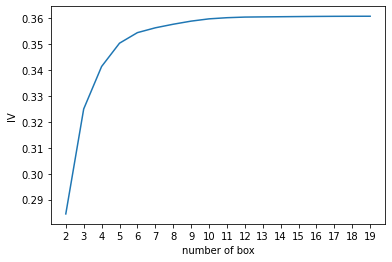

In [14]:
num_bins_ = num_bins.copy() 
import matplotlib.pyplot as plt
import scipy
IV = []
axisx = []
while len(num_bins_) > 2:
    pvs = []
# 获取 num_bins_两两之间的卡方检验的置信度(或卡方值) 
    for i in range(len(num_bins_)-1):
        x1 = num_bins_[i][2:]
        x2 = num_bins_[i+1][2:]
        # 0 返回 chi2 值，1 返回 p 值。
        pv = scipy.stats.chi2_contingency([x1,x2])[1]
        # chi2 = scipy.stats.chi2_contingency([x1,x2])[0] 
        pvs.append(pv)
# 通过 p 值进行处理。合并 p 值最大的两组 
    i = pvs.index(max(pvs)) 
    num_bins_[i:i+2] = [(
        num_bins_[i][0],
        num_bins_[i+1][1],
        num_bins_[i][2]+num_bins_[i+1][2],
        num_bins_[i][3]+num_bins_[i+1][3])]
    bins_df = get_woe(num_bins_) 
    axisx.append(len(num_bins_)) 
    IV.append(get_iv(bins_df))
plt.figure() 
plt.plot(axisx,IV)
plt.xticks(axisx) 
plt.xlabel("number of box") 
plt.ylabel("IV")
plt.show()

In [15]:
# chi2 = scipy.stats.chi2_contingency([x1,x2])[0] 
pv

1.5842695848455614e-291

**将分箱过程包装为方法**

In [16]:
def get_bin(num_bins_,n):
    while len(num_bins_) > n:

        pvs =[]
        for i in range(len(num_bins_)-1):
            x1 = num_bins_[i][2:]
            x2 = num_bins_[i+1][2:]
            pv = scipy.stats.chi2_contingency([x1,x2])[1]
		# chi2 = scipy.stats.chi2_contingency([x1,x2])[0] 
            pvs.append(pv)
        i = pvs.index(max(pvs))
        num_bins_[i:i+2] = [(
		                num_bins_[i][0],
		                num_bins_[i+1][1],
		                num_bins_[i][2]+num_bins_[i+1][2],
		                num_bins_[i][3]+num_bins_[i+1][3])]
    return num_bins_

In [17]:
afterbins = get_bin(num_bins,4)
afterbins

[(21.0, 54.0, 23142, 32831),
 (54.0, 61.0, 6746, 5331),
 (61.0, 74.0, 8863, 3159),
 (74.0, 102.0, 3269, 569)]

In [18]:
# afterbins[0][2:]
# for i in range(len (afterbins)):
    # print(i)
afterbins

[(21.0, 54.0, 23142, 32831),
 (54.0, 61.0, 6746, 5331),
 (61.0, 74.0, 8863, 3159),
 (74.0, 102.0, 3269, 569)]

In [116]:
i=1
[afterbins[i-1][0]
,afterbins[i][1]
,afterbins[i-1][2]
,afterbins[i][2]
,afterbins[i-1][3]+afterbins[i][3]]

[21.0, 61.0, 23142, 6746, 38162]

In [19]:
bins_df = get_woe(num_bins)
bins_df

,min,max,count_0,count_1,total,percentage,bad_rate,good%,bad%,woe
0,21.0,54.0,23142,32831,55973,0.667060,0.586551,0.550738,0.783743,-0.352823
1,54.0,61.0,6746,5331,12077,0.143928,0.441418,0.160543,0.127262,0.232312
2,61.0,74.0,8863,3159,12022,0.143273,0.262768,0.210923,0.075412,1.028531
3,74.0,102.0,3269,569,3838,0.045739,0.148254,0.077796,0.013583,1.745260


**将选取最佳分箱过程包装成函数**

In [20]:
def graphforbestbin(dat,X,Y,n=5,q=20,graph=True):
    """
    自动最优分箱函数，基于卡方检验的分箱
    参数：
    dat:需要输入的数据
    X:需要分箱的列
    Y:分箱数据对应的标签Y
    n:保留分箱个数
    q:初始分箱个数
    graph:是否画图
    """
    dat=dat[[X,Y]].copy()
    #数据分箱
    dat['quct'],bins=pd.qcut(dat[X],retbins=True,q=q,duplicates="drop")
    #求每个分组
    cnt_y0=dat.loc[dat[Y]==0].groupby(by="quct").count()[Y]
    cnt_y1=dat.loc[dat[Y]==1].groupby(by="quct").count()[Y]
    # 拼接区间及Y0和Y1
    num_bins=[*zip(bins,bins[1:],cnt_y0,cnt_y1)]
    # 合并分箱中只有0或者只有1的箱子
    # 合并第一个箱子
    for i in range(q):
        if 0 in num_bins[0][2:]:
            num_bins[0][2:]=[(
                num_bins[0][0]
                ,num_bins[0][1]
                ,num_bins[0][2]+num_bins[1][2]
                ,num_bins[0][3]+num_bins[1][3]
            )]
        #合并之后的箱子
        for i in range(len(num_bins)):
            if 0 in num_bins[i][2:]:
                num_bins[i-1:i+1]=[(
                    num_bins[i-1][0]
                    ,num_bins[i][1]
                    ,num_bins[i-1][2]+num_bins[i][2]
                    ,num_bins[i-1][3]+num_bins[i][3])]
                break
        else:
            break
    #计算woe准备数据
    def get_woe(num_bins):
        columns= ["min","max","count_0","count_1"]
        df=pd.DataFrame(num_bins,columns=columns)
        df['total']=df.count_0+df.count_1
        df['percentage']=df.total/df.total.sum()
        df['bad_rate']=df.count_1/df.total
        df["good%"] = df.count_0/df.count_0.sum()
        df["bad%"] = df.count_1/df.count_1.sum()
        df["woe"] = np.log(df["good%"] / df["bad%"])
        return df
    #计算iv值
    def get_iv(df):
        rate=df['good%']-df['bad%']
        iv=np.sum(rate*df.woe)
        return iv
    
    #根据卡方值合并箱子
    IV=[]
    axisx=[]
    while(len(num_bins)) >n :
        pvs=[]
        for i in range(len(num_bins)-1):
            x1=num_bins[i][2:]
            x2=num_bins[i+1][2:]
            pv=scipy.stats.chi2_contingency(x1,x2)[1]
            pvs.append(pv)
        #找出卡方值最大的值的序号
        i=pvs.index(max(pvs))
        #合并卡方最大组的分箱
        num_bins[i:i+2]=[(
            num_bins[i][0] 
            ,num_bins[i+1][1]
            ,num_bins[i][2]+num_bins[i+1][2]
            ,num_bins[i][3]+num_bins[i+1][3]
        )]
        bins_df=pd.DataFrame(get_woe(num_bins))
        axisx.append(len(num_bins))
        IV.append(get_iv(bins_df))
    if graph:
        plt.figure()
        plt.plot(axisx,IV)
        plt.xticks(axisx)
        plt.xlabel("number of box")
        plt.ylabel("IV")
        plt.show()
        
    return bins_df


In [21]:
model_data.columns

Index(['Unnamed: 0', 'SeriousDlqin2yrs',
       'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'qcut'],
      dtype='object')

In [37]:
# 自动分箱字段
auto_col_bins = {"RevolvingUtilizationOfUnsecuredLines":6,"age":5,"DebtRatio":4,"MonthlyIncome":3,"NumberOfOpenCreditLinesAndLoans":5} 
 #不能使用自动分箱的变量
hand_bins = {"NumberOfTime30-59DaysPastDueNotWorse":[0,1,2,13]
 ,"NumberOfTimes90DaysLate":[0,1,2,17]
 ,"NumberRealEstateLoansOrLines":[0,1,2,4,54]
 ,"NumberOfTime60-89DaysPastDueNotWorse":[0,1,2,8]
 ,"NumberOfDependents":[0,1,2,3]}
 #保证区间覆盖使用 np.inf替换最大值，用-np.inf替换最小值
hand_bins = {k:[-np.inf,*v[:-1],np.inf] for k,v in hand_bins.items()}

In [ ]:
graphforbestbin(model_data,'age',"SeriousDlqin2yrs",n=auto_col_bins[col],q=20,graph=True)

RevolvingUtilizationOfUnsecuredLines


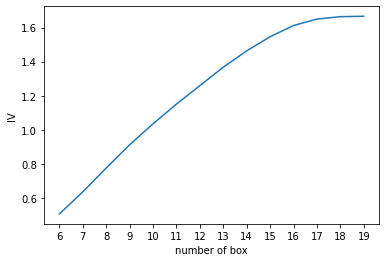

age


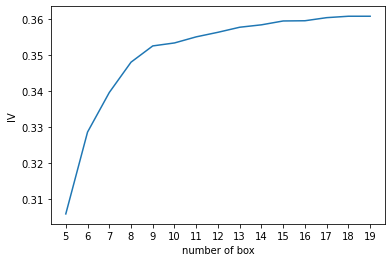

DebtRatio


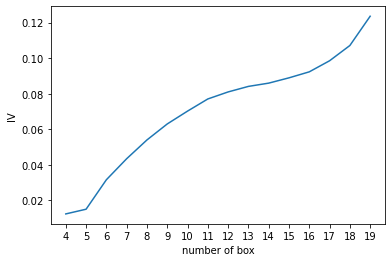

MonthlyIncome


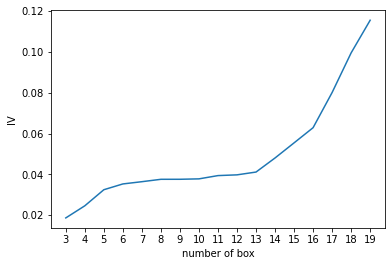

NumberOfOpenCreditLinesAndLoans


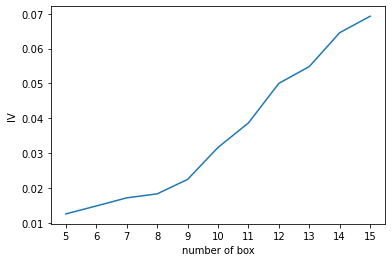

In [35]:
for col in auto_col_bins:
    print(col)
    graphforbestbin(model_data,col,"SeriousDlqin2yrs",n=auto_col_bins[col],q=20,graph=True)

In [28]:
for i in model_data.columns[1:-1]:
    print(i)
    graphforbestbin(model_data,i,"SeriousDlqin2yrs",n=2,q=2,graph=True)

SeriousDlqin2yrs


ValueError: Input array must be 1 dimensional